## Imports

In [1]:
%env CUDA_VISIBLE_DEVICES=1
%matplotlib inline

env: CUDA_VISIBLE_DEVICES=1


In [2]:
import os                                                                       
import numpy as np                                                              
import tensorflow as tf                                                         
import data.data_selector as ds                                                   
import utils.plot_functions as pf                                               
import analysis.analysis_picker as ap

In [12]:
analysis_params = {
  "model_type": "conv_lca",
  "model_name": "conv_lca_vh_patch",
  "device": "/gpu:0",
  "version": "0.0",
  "num_inference_images": 3, #How many random images to average over for inference statistics
  "num_inference_steps": 20,
  "clobber": True}

# Computed params
analysis_params["model_dir"] = (os.path.expanduser("~")+"/Work/Projects/"
  +analysis_params["model_name"])

In [4]:
analyzer = ap.get_analyzer(analysis_params)

In [5]:
data = ds.get_data(analyzer.model_params)
data = analyzer.model.preprocess_dataset(data, analyzer.model_params)
data = analyzer.model.reshape_dataset(data, analyzer.model_params)
analyzer.model.setup(analyzer.model_params, analyzer.model_schedule)
analyzer.model_params["data_shape"] = list(data["train"].shape[1:])

In [6]:
#print("Analysis params:\n")
#print("\n".join([key.ljust(20)+"\t"+str(analyzer.model_params[key]) for key in analyzer.model_params]))

##### Notes
a_vals during inference are extremely high for conv lca on cifar
this is causing inf in loss values
need to train new conv lca on VH whitened
figure out a_vals for those
what in conv LCA would be causing the values to be so high??

In [7]:
if analysis_params["clobber"]:
  analyzer.run_analysis(data["train"].images, save_info="test")
else:
  analyzer.load_analysis(save_info="full_imgs")

INFO:tensorflow:Restoring parameters from /home/dpaiton/Work/Projects/conv_lca_vh_patch/checkpoints/conv_lca_vh_patch_v0.0_weights-5000


INFO:tensorflow:Restoring parameters from /home/dpaiton/Work/Projects/conv_lca_vh_patch/checkpoints/conv_lca_vh_patch_v0.0_weights-5000


INFO:tensorflow:Restoring parameters from /home/dpaiton/Work/Projects/conv_lca_vh_patch/checkpoints/conv_lca_vh_patch_v0.0_weights-5000


INFO:tensorflow:Restoring parameters from /home/dpaiton/Work/Projects/conv_lca_vh_patch/checkpoints/conv_lca_vh_patch_v0.0_weights-5000


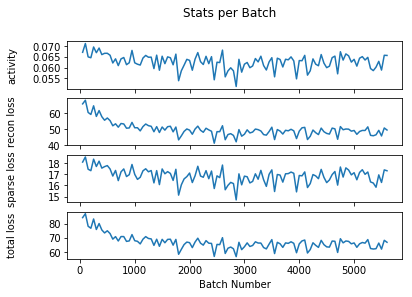

In [8]:
stats_fig = pf.plot_stats(analyzer.run_stats,
  keys=["a_fraction_active", "recon_loss", "sparse_loss", "total_loss"],
  labels=["activity", "recon loss", "sparse loss", "total loss"])

In [9]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits import axes_grid1
import utils.data_processing as dp

def plot_inference_stats(data, title="", save_filename=None):
  """
  Plot loss values during LCA inference
  Inputs:
    data: [dict] that must contain the "losses"
      this can be created by using the LCA analyzer objects
  """
  labels = [key for key in data["losses"].keys()]
  losses = [val for val in data["losses"].values()]
  num_im, num_steps = losses[0].shape
  means = [None,]*len(labels)
  sems = [None,]*len(labels)
  for loss_id, loss in enumerate(losses):
    means[loss_id] = np.mean(loss, axis=0) # mean across num_imgs
    sems[loss_id] = np.std(loss, axis=0) / np.sqrt(num_im)
  num_plots_y = np.int32(np.ceil(np.sqrt(len(labels))))+1
  num_plots_x = np.int32(np.ceil(np.sqrt(len(labels))))
  gs = gridspec.GridSpec(num_plots_y, num_plots_x)
  fig = plt.figure(figsize=(10,10))
  loss_id = 0
  for plot_id in np.ndindex((num_plots_y, num_plots_x)):
    (y_id, x_id) = plot_id
    ax = fig.add_subplot(gs[plot_id])
    if loss_id < len(labels):
      time_steps = np.arange(num_steps)
      ax.plot(time_steps, means[loss_id], "k-")
      ax.fill_between(time_steps, means[loss_id]-sems[loss_id],
        means[loss_id]+sems[loss_id], alpha=0.2)
      ax.set_ylabel(labels[loss_id].replace('_', ' '), fontsize=16)
      ax.set_xlim([1, np.max(time_steps)])
      ax.set_xticks([1, int(np.floor(np.max(time_steps)/2)), np.max(time_steps)])
      ax.set_xlabel("time step", fontsize=16)
      ax.tick_params("both", labelsize=14)
      loss_id += 1
    else:
      ax = pf.clear_axis(ax, spines="none")
  fig.tight_layout()
  fig.suptitle(title, y=1.03, x=0.5, fontsize=20)
  if save_filename is not None:
    fig.savefig(save_filename, transparent=True)
    plt.close(fig)
    return None
  plt.show()
  return fig

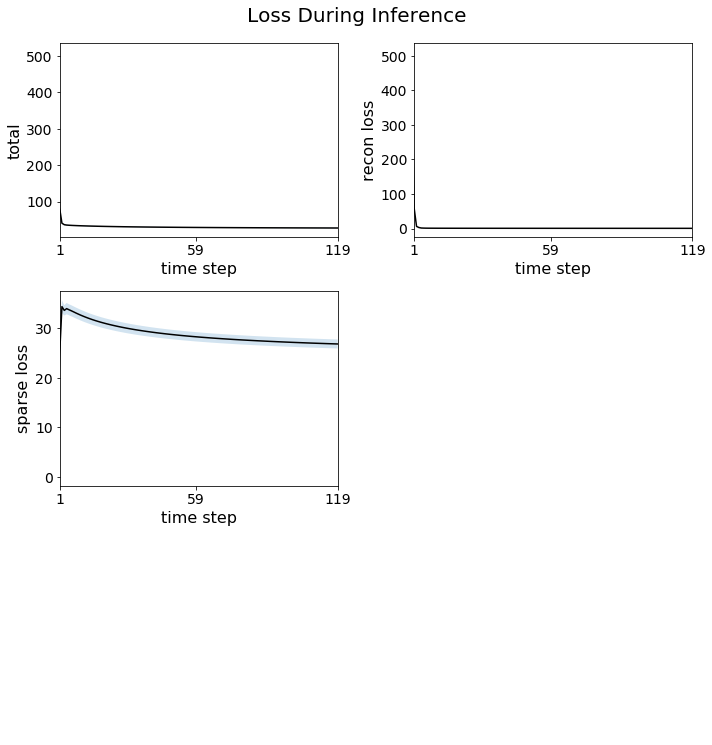

In [16]:
fig = plot_inference_stats(analyzer.inference_stats, title="Loss During Inference")

In [ ]:
num_pixels, num_neurons = analyzer.atas.shape
atas_fig = pf.plot_data_tiled(analyzer.atas.T.reshape(num_neurons,
  int(np.sqrt(num_pixels)), int(np.sqrt(num_pixels))), normalize=False,
  title="Activity triggered averages on image data")

In [ ]:
noise_images = np.random.standard_normal(data["train"].images.shape) 
noise_evals = analyzer.evaluate_model(noise_images, analyzer.var_names)
noise_atas = analyzer.compute_atas(noise_evals["inference/activity:0"],
  noise_images)
noise_atas_fig = pf.plot_data_tiled(noise_atas.T.reshape(num_neurons,
  int(np.sqrt(num_pixels)), int(np.sqrt(num_pixels))), normalize=False,
  title="Activity triggered averages on standard normal noise data")

In [ ]:
dict_fig = pf.plot_data_tiled(analyzer.evals["weights/phi:0"].T.reshape(analyzer.model.num_neurons,
  data["train"].num_cols, data["train"].num_rows), normalize=False, title="Weights")

In [ ]:
inference_fig = pf.plot_inference_traces(analyzer.inference_stats, analyzer.model_schedule[0]["sparse_mult"])

In [ ]:
fig = pf.plot_inference_stats(analyzer.inference_stats, title="Loss During Inference")